# FITS 

In this tutorial we demostrate how to retrieve data from FITS and also how to find sites and data collection methods.

## Set Up 

###### Import packages

In [1]:
import json # package to read json code
import requests # package to get data from an API
import pandas as pd # package for data frames
import datetime # package to deal with time
import matplotlib.pyplot as plt #package to do plotting

## Basic Functionality - Get Observation Data

Set URL

In [2]:
base_url = 'https://fits.geonet.org.nz/'
endpoint = 'observation'

Set query parameters

We need to set
- siteID, where data are collected
- typeID, type of data collected

We can optionally set
- methodID, how data were collected. This potentially allows you to distinguish data with different collection methods.
- days, the last n days of data. This is counted back from today. 

### GNSS data example

Retrieve daily GNSS positions from Makorori (MAKO), a site near Gisborne. You'll notice that these data have non-zero errors that were estimated when the daily positions were calculated. In this case we will retrieve all the data, so the days=xxx option is not required.

In [3]:
siteID = 'MAKO' #Makorori
typeID = 'e' #east component of deformation

In [4]:
url = base_url + endpoint+'?typeID=' + typeID + '&siteID=' + siteID
print (url)

https://fits.geonet.org.nz/observation?typeID=e&siteID=MAKO


Use the url specifying the data request in pandas read_csv function. Tell pandas to interpret columns that look like dates as dates, ans set the index to the date-time column

In [5]:
df = pd.read_csv(url, parse_dates=True, index_col='date-time')

Head the dataframe to check the first 5 rows

In [6]:
df.head()

,e (mm),error (mm)
date-time,,
2010-11-10 11:59:00+00:00,24.11,1.78
2010-11-11 11:59:00+00:00,23.15,1.83
2010-11-12 11:59:00+00:00,25.73,1.96
2010-11-13 11:59:00+00:00,24.78,1.72
2010-11-14 11:59:00+00:00,23.73,2.24


Make a basic plot directly using the pandas plot function

<Axes: xlabel='date-time'>

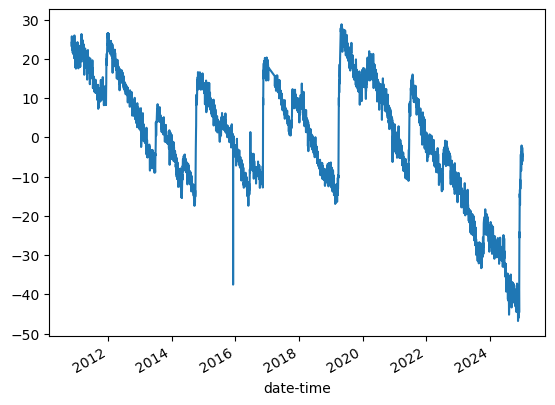

In [7]:
df[' e (mm)'].plot()

## Additional Functionality - Find Sites

You can use the FITS API to find sites in a particular area. https://fits.geonet.org.nz/api-docs/endpoint/site We use a ploygon around Tair&#259;whiti (East Cape). The kind of data present in FITS is not returned, but in this case all sites provide GNSS daily position solutions.

In [8]:
base_url = 'https://fits.geonet.org.nz/'
endpoint = 'site'
url = base_url + endpoint

In [9]:
poly = 'POLYGON((177.3 -38.2, 177.8 -37.4, 178.7 -37.6, 178.4 -38.8, 177.3 -38.2))'
parameters ={'within':poly}

We use `requests.get` to get the data using the URL and the polygon parameters

In [10]:
sites = requests.get(url, params=parameters)
print (sites) # a 200 response is okay

data = sites.json()['features'] # we want the features information

<Response [200]>


Create a dataframe to store the site information

In [11]:
eastcape = pd.DataFrame() #empty dataframe

We put this data into a dataframe

In [12]:
for i, val in enumerate(data):
    geometry = val['geometry']
    lon = geometry['coordinates'][0]
    lat = geometry['coordinates'][1]
    properties = val['properties']
    siteID = properties['siteID']
    height = properties['height']
    name = properties['name']
    #dictionary containing the various data
    dic = {'siteID': siteID, 'lon': lon, 'lat': lat, 'height': height, 'name': name}
    #make a temprary dataframe from the dictionary
    temp = pd.DataFrame(dic, index=[i])
    #concatenate with dataframe containing site information
    eastcape = pd.concat([eastcape, temp])

In [13]:
eastcape

,siteID,lon,lat,height,name
0,HIKB,178.303352,-37.561041,107.3013,Hicks Bay
1,AHTI,178.046003,-38.411448,563.2210,Ahititi
2,PAKI,178.082600,-37.893980,828.0000,Pakihiroa
3,ANAU,178.291223,-38.268213,229.3040,Anaura Bay
4,TAUW,178.005877,-38.162425,713.4560,Tauwhareparae
5,MAKO,178.129135,-38.643795,255.0300,Makorori
6,PUKE,178.257360,-38.071415,468.0750,Puketiti
7,WMAT,178.408700,-37.825000,356.0000,Waiomatatini
8,TKAR,177.811440,-38.437470,287.0000,Te Karaka
9,CNST,178.211144,-38.487966,242.6788,Carnagh Station


## Additional Functionality - Find Data Collection Methods

You can use the FITS API to find data collection methods for a particular data type. https://fits.geonet.org.nz/api-docs/endpoint/method We use it to find the methods for GNSS daily solution data. We set data type to 'e', but 'n' and 'u' would give the same results.

In [14]:
base_url = 'https://fits.geonet.org.nz/'
endpoint = 'method'
url = base_url + endpoint

In [15]:
#Set query parameters
parameters ={"typeID": 'e'}

#Get data
request = requests.get(url, params=parameters)

#Unpack data
data = request.json()['method']

In [16]:
e_methods = pd.DataFrame()
    
#add data to the data frame
for i, val in enumerate(data):
    methodID = val['methodID']
    name = val['name']
    description = val['description']
    reference = val['reference']
    #append these to t_methods
    dic = {'name': name, 'methodID': methodID, 'description': description, 'reference':reference}
    #make a temprary dataframe from the dictionary
    temp = pd.DataFrame(dic, index=[i])
    #concatenate with dataframe containing method information
    e_methods = pd.concat([e_methods, temp])

In [17]:
e_methods

,name,methodID,description,reference
0,Bernese v5.0,bernese5,Bernese v5.0 GNS processing software,http://info.geonet.org.nz/x/XoIW
1,Gamit/GlobK,gamit,Gamit/GlobK GNSS processing software,http://www-gpsg.mit.edu/~simon/gtgk/
